In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
from torch.utils.data import DataLoader, Dataset, random_split
import torch
import torch.nn as nn
from torchvision.io import read_image
import torchvision.transforms as transforms
from torchvision import datasets
from torch import optim
import os
import torchvision

In [3]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [4]:
transforms = transforms.Compose([
    transforms.ToTensor()
])

In [62]:
class CustomDataset(Dataset):
    def __init__(self, labels_file, imgs_dir, transform=None, target_transform=None):
        self.labels = pd.read_csv(labels_file)
        self.imgs_dir = imgs_dir
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        img_path = os.path.join(self.imgs_dir, self.labels.iloc[idx, 0])
        image = torch.tensor(read_image(img_path), dtype=torch.float32)
        label = torch.tensor(self.labels.iloc[idx, 1], dtype=torch.int64)
        #if self.transform:
        #    image = self.transform(image)
        #if self.target_transform:
        #    label = self.target_transform(label)
        return image, label

In [63]:
training_dataset = CustomDataset('data/Train/Train.csv', 'data/Train/')
validation_dataset = CustomDataset('data/Valid/Validation.csv', 'data/Valid/')

In [64]:
training_loader = DataLoader(training_dataset, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

In [65]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import os
import matplotlib.pyplot as plt
from skimage.feature import hog
import random
import cv2

In [67]:
def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

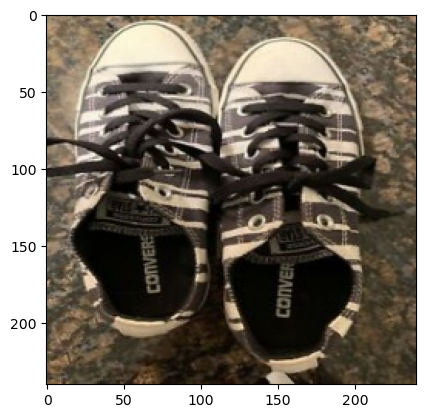

In [68]:
imshow(validation_dataset.__getitem__(10)[0])

In [8]:
from torch import optim
import torch.nn as nn

In [9]:
net = nn.Sequential(
    nn.Flatten(),
    nn.Linear(3*240*240, 1),
    nn.Softmax(),
).cuda()

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [11]:
def train(dl, model, loss_fn, opt):
    size = len(dl.dataset)
    model.train()
    for batch, (image, label) in enumerate(dl):
        image = image.to("cuda")
        label = label.to("cuda")
        pred = model(image)
        loss = loss_fn(pred, label)
        loss.backward()
        opt.step()
        opt.zero_grad()

        if batch % 5==0:
            print(f"loss: {loss.item()}    [{(batch+1)*len(image)}/{size}]")

In [12]:
def evaluate(dl, model, loss_fn, opt):
    size = len(dl.dataset)
    num_batches = len(dl)
    model.eval()
    test_loss, total_correct = 0, 0
    with torch.no_grad():
        for image, label in dl:
            image, label = image.to(device), label.to(device)
            pred = model(image)
            loss = loss_fn(pred, label)
            test_loss += loss.item()
            correct = (pred.argmax(1) == label).sum().item()
            total_correct += correct        
    average_loss = test_loss / num_batches
    accuracy = total_correct / size
    print(f"Accuracy = {(100*accuracy):>0.1f}%, Avg_Loss = {average_loss}")

In [13]:
for epoch in range(5):
    print(f"====== Epoch {epoch+1} ======")
    train(training_loader, net, loss_fn, optimizer)
    evaluate(validation_loader, net, loss_fn, optimizer)
print("Done!")

====== Epoch 1 ======


C:\Users\Omar\AppData\Local\Temp\ipykernel_18516\3751548059.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(read_image(img_path), dtype=torch.float32)
C:\Users\Omar\anaconda3\Lib\site-packages\torch\nn\modules\module.py:1532: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
